In [67]:
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torch import nn
import os
from sklearn.cluster import KMeans
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torchvision import models
from torch import nn
import torch
from torch.optim import lr_scheduler
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import normalized_mutual_info_score
from PIL import Image
import seaborn as sns
from torchvision.models import resnet18

In [5]:
import torchvision
import torch
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
import numpy as np
from torch.optim import lr_scheduler
import time
from sklearn.preprocessing import StandardScaler

In [6]:
from glob import glob
import pandas as pd

In [7]:
%cd /content/drive/MyDrive/MLDM project

[Errno 2] No such file or directory: '/content/drive/MyDrive/MLDM project'
/content


In [8]:
path = '/content/drive/MyDrive/10 imgs.rar (Unzipped Files)/10 imgs/'

In [9]:
batch_size_test = 32
batch_size_train = 32

In [10]:
classes = os.listdir(path)[:-1]

In [11]:
classes

['apple_pie',
 'baklava',
 'baby_back_ribs',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
data = pd.DataFrame({})
imgs = []
labels = []
for i in classes:
  for j in glob(f'{path}{i}/*.jpg'):
    imgs.append(j)
    labels.append(i)
data['images'] = imgs
data['labels'] = labels

In [13]:
data = data.sample(frac=1).reset_index(drop=True)

In [14]:
data.head()

,images,labels
0,/content/drive/MyDrive/10 imgs.rar (Unzipped F...,bread_pudding
1,/content/drive/MyDrive/10 imgs.rar (Unzipped F...,baklava
2,/content/drive/MyDrive/10 imgs.rar (Unzipped F...,beef_tartare
3,/content/drive/MyDrive/10 imgs.rar (Unzipped F...,breakfast_burrito
4,/content/drive/MyDrive/10 imgs.rar (Unzipped F...,beef_tartare


In [15]:
data.shape

(9882, 2)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data['images'], data['labels'], test_size=0.2, random_state=42)

In [18]:
from sklearn import preprocessing

In [19]:
class Foods(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
    ])
    self.encoder = {}
    idx = 0
    for i in np.unique(labels):
      if self.encoder.get(i) == None:
        self.encoder[i] = idx
        idx += 1


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    # img = Image.open(self.images[idx])
    img = cv2.imread(self.images[idx])
    img = self.my_transforms(img)
    label = self.labels[idx]
    return img, self.encoder[label]


In [20]:
train_loader = torch.utils.data.DataLoader(Foods(X_train.values, y_train.values), batch_size=batch_size_train , shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(Foods(X_test.values, y_test.values), batch_size=batch_size_test , shuffle=True, pin_memory=True)

In [28]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

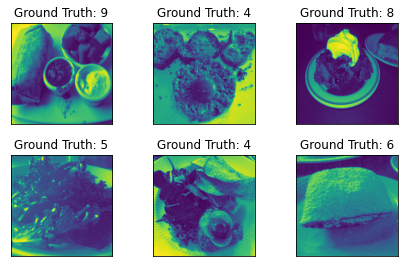

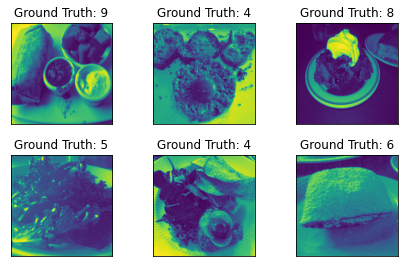

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0])
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [116]:
class SSL(nn.Module):
    
    def __init__(self):
        super().__init__()
        model = resnet18()
        conv_layers = [i for i in model._modules]
        print(conv_layers)
        
        self.conv1 = nn.Sequential(*[model._modules[i] for i in conv_layers[:-1]])
        self.fc1 = nn.Sequential(nn.Linear(512, 10))


        
    def forward(self, x):
      x = self.conv1(x)
      x = x.view(-1, 512)
      out = x
      x = self.fc1(x)
      return x,out

In [117]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':X_train.shape[0],
    'val':X_test.shape[0]
}

In [118]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [119]:
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=128, max_iter=1000, init_size=3*100)

In [120]:
device

device(type='cuda', index=0)

In [138]:
def extract_featurse(dataset, model, cluster, cl_number):
  loc_model = model.to(cpu)
  featurse = []
  for image, _ in tqdm(dataset, desc='extracting features'):
    _, vector = loc_model(image)
    vector = vector.detach().numpy()
    for i in vector:
      featurse.append(i)
  featurse = np.array(featurse)
  cl_alg = cluster(n_clusters=cl_number)
  cl_alg.fit(featurse)
  return cl_alg


In [142]:
def train_model(model, criterion_class, optimizer, num_epochs=25, c=1000):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = 5
    first_time = True

    flag_cluster = True


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        print('cluster processing')

        kmeans = extract_featurse(dataloaders['train'], model, KMeans, 10)
        model = model.to(device)

        # Each epoch has a training and validation phase
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = []
            train_acc = []
            val_acc = []
            cluster_acc = []

            batch_num = 0
            # Iterate over data.
            for inputs, class_labels in dataloaders[phase]:

                inputs = inputs.to(device)
                class_labels = class_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
              
                    class_out, vectors = model(inputs)
                    _, preds = torch.max(class_out, 1)
                    vectors = vectors.to(cpu)
                    vectors_np = vectors.detach().numpy()

                    
                    cluster_labels = kmeans.predict(vectors_np)

                    clust_sam = cluster_labels.copy()
                    cluster_labels = torch.from_numpy(cluster_labels).long().to(device)
                    loss = criterion_class(class_out,cluster_labels)
                    
                    if (phase == 'train'):
                        loss.backward()
                        optimizer.step()
                        cluster = True

                    class_labels_clone = class_labels.clone().to(cpu).detach().numpy()
                    preds_clone = preds.clone().to(cpu).detach().numpy()

                    my_score = normalized_mutual_info_score(class_labels_clone,preds_clone )
                    cluster_acc.append(normalized_mutual_info_score(class_labels_clone,clust_sam))



                running_loss += loss.item() * inputs.size(0)
                running_corrects.append(normalized_mutual_info_score(class_labels_clone,preds_clone ))


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = np.mean(running_corrects)
            plt.plot(running_corrects)
            plt.xlabel(f'number of batch fro phase {phase}')
            plt.grid(True)
            plt.show()
            print(f'{phase} Loss: {epoch_loss:.4f} acc: {epoch_acc:.4f} cluster_acc: {np.mean(cluster_acc)}')

            if phase == 'val' and epoch_loss < best_epoch_loss:
                best_epoch_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())





    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best : {:4f}'.format( best_epoch_loss))


    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), './models/model')
    return model

In [144]:
net = SSL()
criterion_class = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=0.002)
net = net.to(device)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


Epoch 0/3
----------
cluster processing


extracting features: 100%|██████████| 248/248 [12:14<00:00,  2.96s/it]


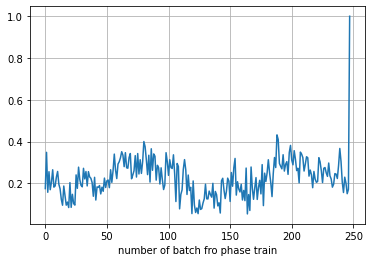

train Loss: 0.6651 acc: 0.2269 cluster_acc: 0.2677401915888124


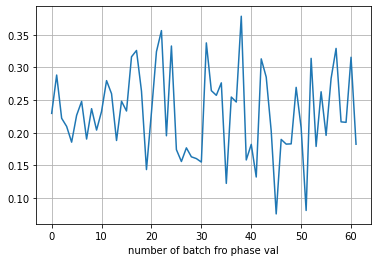

val Loss: 0.2035 acc: 0.2299 cluster_acc: 0.2460107403624696
Epoch 1/3
----------
cluster processing


extracting features: 100%|██████████| 248/248 [11:16<00:00,  2.73s/it]


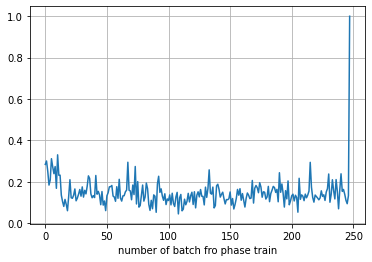

train Loss: 0.5014 acc: 0.1475 cluster_acc: 0.15041074223478096


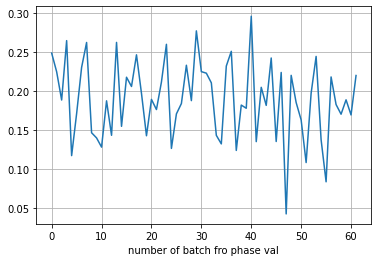

val Loss: 1.7967 acc: 0.1892 cluster_acc: 0.23516120978011926
Epoch 2/3
----------
cluster processing


extracting features: 100%|██████████| 248/248 [11:13<00:00,  2.72s/it]


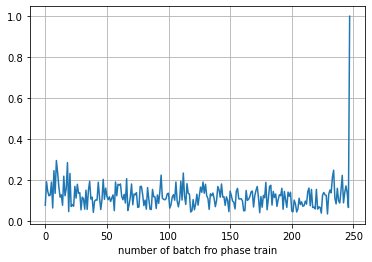

train Loss: 0.1426 acc: 0.1230 cluster_acc: 0.12491608081237579


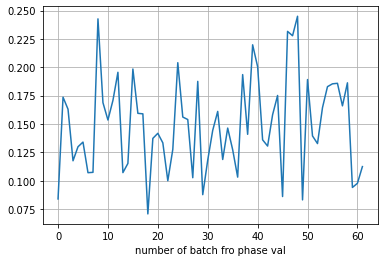

val Loss: 2.2725 acc: 0.1496 cluster_acc: 0.18999418453412825
Epoch 3/3
----------
cluster processing


extracting features:   4%|▍         | 10/248 [00:29<11:49,  2.98s/it]


KeyboardInterrupt: ignored

In [145]:
model_ft_tf = train_model(net, criterion_class, optimizer_ft, num_epochs=4)